#### install the required packages

In [3]:
# !pip install transformers

In [4]:
# !pip install datasets

In [6]:
# ! pip install datasets

In [17]:
# ! pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio===0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

### Problem 13

#### 13.1 import packages, raw data, models, etc.

In [ ]:
# # debug
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import transformers
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict, ClassLabel
from sklearn.metrics import f1_score, mean_absolute_error
import random

In [3]:
from torch import nn
import torch
from transformers import Trainer, TrainingArguments, pipeline

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.current_device()

0

In [6]:
torch.cuda.device_count()

1

In [7]:
torch.cuda.get_device_name(0)

'Tesla V100-PCIE-16GB'

In [8]:
device = torch.device("cuda:0")

In [9]:
# load the data
train_data = pd.read_csv('si630w22-hw3-train.csv')
test_data = pd.read_csv('si630w22-hw3-test.public.csv')
text_data = pd.read_csv('si630w22-hw3-data.csv')
dev_data = pd.read_csv('si630w22-hw3-dev.csv')

In [11]:
# Call the tokenizer
# Call the pretrained model
model_ckpt = 'microsoft/MiniLM-L12-H384-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_text(examples):
    return tokenizer(examples['text'], truncation=True, max_length=512)

In [13]:
from transformers import AutoModelForSequenceClassification as AMFSC
model = AMFSC.from_pretrained(model_ckpt, num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions
    mse = mean_absolute_error(labels, preds)
    return {'mse': mse}

#### 13.2 Train and test the model

In [27]:
text_data['text'] = text_data[['question_text', 'reply_text']].agg(' [SEP] '.join, axis=1)

g_lst = []
a_lst = []
b_lst = []
c_lst = []


def load_data_to_dataset(text_df, df, is_test_data = False):

    if is_test_data == True:
        df_processed = df
        merge_df = pd.merge(df_processed, text_df, left_on='id',right_on='question_id',how='inner')
        data = merge_df[['question_id','text','rating']]
        
#         output = Dataset.from_pandas(data, preserve_index=False)
        output = data
        
    else:
        df_processed = df.groupby('id').mean('rating')
        merge_df = pd.merge(df_processed, text_df, left_on='id',right_on='question_id',how='inner')

        data = merge_df[['question_id','text','rating']]
        data = data.rename(columns={'rating': 'labels'})
        data['labels']= data['labels']

        output = Dataset.from_pandas(data, preserve_index=False)

    
    return output


group_lst = dev_data['group'].unique()
for group in group_lst:
#     n = 0
    print(group)
    # a b c data definition
    dev_data_a = dev_data.copy()
    dev_data_a['rating'] = np.random.randint(1, 6, dev_data.shape[0])
    grouped_a = dev_data_a.groupby(['group','id'])['rating'].mean()
    grouped_a = grouped_a.to_frame()
    grouped_a = grouped_a.reset_index()
    grouped_a = grouped_a[grouped_a['group'] == group]
    
    a = grouped_a[['id','rating']].reset_index(drop=True)
    
#     group_b = dev_data.groupby(['group','id'])['rating'].mean().to_frame().reset_index()
#     group_b = group_b[group_b['group'] == group][['id','rating']].reset_index(drop=True)

    
#     b = group_b
    b = dev_data[(dev_data['id'].isin(dev_data[dev_data['group'] == group].id.unique())) & (dev_data['group'] == group)].groupby('id').mean('rating').reset_index()
    c = dev_data[(dev_data['id'].isin(dev_data[dev_data['group'] == group].id.unique())) & (dev_data['group'] != group)].groupby('id').mean('rating').reset_index()
    
    
    # train data definition
    train_group_data = train_data[train_data['group'] == group]
    train_ds = load_data_to_dataset(text_data, train_group_data, is_test_data = False)
    train_ds = train_ds.map(tokenize_text, batched=True)
    
    
    # model args
    batch_size = 32
    logging_steps = len(train_ds) // batch_size
    output_dir = 'minln-finetuned-rating-regression'
    training_args = TrainingArguments(output_dir=output_dir,
                                      num_train_epochs=5,
                                      learning_rate=2e-5,
                                      per_device_train_batch_size=batch_size,
                                      per_device_eval_batch_size=batch_size,
    #                                   evaluation_strategy='epoch',
                                      save_strategy = 'epoch',
                                      logging_steps=logging_steps,
                                      overwrite_output_dir=True,
                                      push_to_hub=False,
                                      fp16=True
                                     )

    
    # model parameter
    trainer = Trainer(model = model, 
                      args = training_args, 
                      train_dataset = train_ds, 
#                       eval_dataset = None,
                      compute_metrics = compute_metrics,
                      tokenizer = tokenizer)
    # training model
    trainer.train()
    
    location = '/home/conanwu/minln-finetuned-rating-regression/checkpoint-50'
    pipe = pipeline("text-classification", model=location, function_to_apply="none", truncation=True, max_length=512)
    
    g_lst.append(group)
    
    # testing model
    i_count = 0
    for i in a,b,c:
        test_group_data = i

        test_ds = load_data_to_dataset(text_data, test_group_data, is_test_data = True)
        

        def return_score(text):
            return pipe(text)[0]['score']
        
        
        test_ds['predicted'] = test_ds['text'].apply(return_score)
        
        corr_num = test_ds.corr(method='pearson').iloc[1][0]
        if i_count == 0:
            a_lst.append(corr_num)
        elif i_count == 1:
            b_lst.append(corr_num)
        elif i_count == 2:
            c_lst.append(corr_num)
        
        i_count += 1
        
#     n += 1
#     if n == 1:
#         break

# save the result
output_p13_dict = {'group':g_lst, 'a':a_lst, 'b':b_lst, 'c':c_lst}
output_p13_df = pd.DataFrame(output_p13_dict)

output_p13_df.to_csv('output_p13.csv')

group_09


  0%|          | 0/1 [00:00<?, ?ba/s]

Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 307
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss
9,18.530900
18,17.640200
27,16.115500
36,14.466300
45,13.394900


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_03


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 310
  Num Epochs = 5
  I

Step,Training Loss
9,10.836800
18,9.516700
27,8.945800
36,8.111400
45,7.674600


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_10


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 302
  Num Epochs = 5
  I

Step,Training Loss
9,6.542000
18,5.871700
27,5.343700
36,4.656300
45,4.703100


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_13


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 303
  Num Epochs = 5
  I

Step,Training Loss
9,5.761100
18,4.998900
27,4.568600
36,4.113100
45,3.854000


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_22


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 311
  Num Epochs = 5
  I

Step,Training Loss
9,1.120000
18,0.862700
27,0.606700
36,0.617900
45,0.519100


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_01


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 293
  Num Epochs = 5
  I

Step,Training Loss
9,1.950100
18,1.754000
27,1.642600
36,1.649100
45,1.463600


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_02


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 288
  Num Epochs = 5
  I

Step,Training Loss
9,1.047500
18,0.898100
27,0.797300
36,0.761400
45,0.749900


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-9
Configuration saved in minln-finetuned-rating-regression/checkpoint-9/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-9/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-9/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-9/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-18
Configuration saved in minln-finetuned-rating-regression/checkpoint-18/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-18/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-18/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-18/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-27
Configuration saved in minln-fin

group_20


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 294
  Num Epochs = 5
  I

Step,Training Loss
9,0.538000
18,0.378600
27,0.293600
36,0.299900
45,0.263900


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_04


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 304
  Num Epochs = 5
  I

Step,Training Loss
9,0.472700
18,0.438400
27,0.410000
36,0.342000
45,0.368300


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_12


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 298
  Num Epochs = 5
  I

Step,Training Loss
9,0.659500
18,0.619200
27,0.598900
36,0.604500
45,0.510500


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_15


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 317
  Num Epochs = 5
  I

Step,Training Loss
9,0.384000
18,0.330600
27,0.308100
36,0.305800
45,0.330400


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_24


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 294
  Num Epochs = 5
  I

Step,Training Loss
9,0.627700
18,0.725400
27,0.571500
36,0.571700
45,0.528200


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_17


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 315
  Num Epochs = 5
  I

Step,Training Loss
9,0.576400
18,0.547600
27,0.435200
36,0.409900
45,0.540700


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_25


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 313
  Num Epochs = 5
  I

Step,Training Loss
9,0.553600
18,0.385900
27,0.277000
36,0.302700
45,0.220800


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_19


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 314
  Num Epochs = 5
  I

Step,Training Loss
9,0.379600
18,0.447800
27,0.306500
36,0.385600
45,0.301800


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_08


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 302
  Num Epochs = 5
  I

Step,Training Loss
9,0.587800
18,0.197700
27,0.190200
36,0.169000
45,0.188000


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_07


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 306
  Num Epochs = 5
  I

Step,Training Loss
9,2.286700
18,0.489600
27,0.344700
36,0.340600
45,0.373200


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_18


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 308
  Num Epochs = 5
  I

Step,Training Loss
9,0.400800
18,0.367400
27,0.338600
36,0.341000
45,0.316300


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_21


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 301
  Num Epochs = 5
  I

Step,Training Loss
9,0.738500
18,0.389200
27,0.318500
36,0.276100
45,0.320700


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_16


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 295
  Num Epochs = 5
  I

Step,Training Loss
9,0.648500
18,0.524800
27,0.423800
36,0.451000
45,0.384200


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_23


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 304
  Num Epochs = 5
  I

Step,Training Loss
9,1.081300
18,0.582100
27,0.717800
36,0.581800
45,0.508700


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_05


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 302
  Num Epochs = 5
  I

Step,Training Loss
9,0.400200
18,0.375400
27,0.354100
36,0.272500
45,0.302100


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

group_14


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 283
  Num Epochs = 5
  I

Step,Training Loss
8,0.555600
16,0.309100
24,0.317500
32,0.273300
40,0.252600


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-9
Configuration saved in minln-finetuned-rating-regression/checkpoint-9/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-9/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-9/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-9/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-18
Configuration saved in minln-finetuned-rating-regression/checkpoint-18/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-18/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-18/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-18/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-27
Configuration saved in minln-fin

group_11


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: question_id, text. If question_id, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/conanwu/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 298
  Num Epochs = 5
  I

Step,Training Loss
9,0.416800
18,0.408300
27,0.363800
36,0.288100
45,0.327600


Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-10
Configuration saved in minln-finetuned-rating-regression/checkpoint-10/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-10/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-10/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-10/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-20
Configuration saved in minln-finetuned-rating-regression/checkpoint-20/config.json
Model weights saved in minln-finetuned-rating-regression/checkpoint-20/pytorch_model.bin
tokenizer config file saved in minln-finetuned-rating-regression/checkpoint-20/tokenizer_config.json
Special tokens file saved in minln-finetuned-rating-regression/checkpoint-20/special_tokens_map.json
Saving model checkpoint to minln-finetuned-rating-regression/checkpoint-30
Configuration saved in minl

In [30]:
output_p13_df = output_p13_df.sort_values('group')

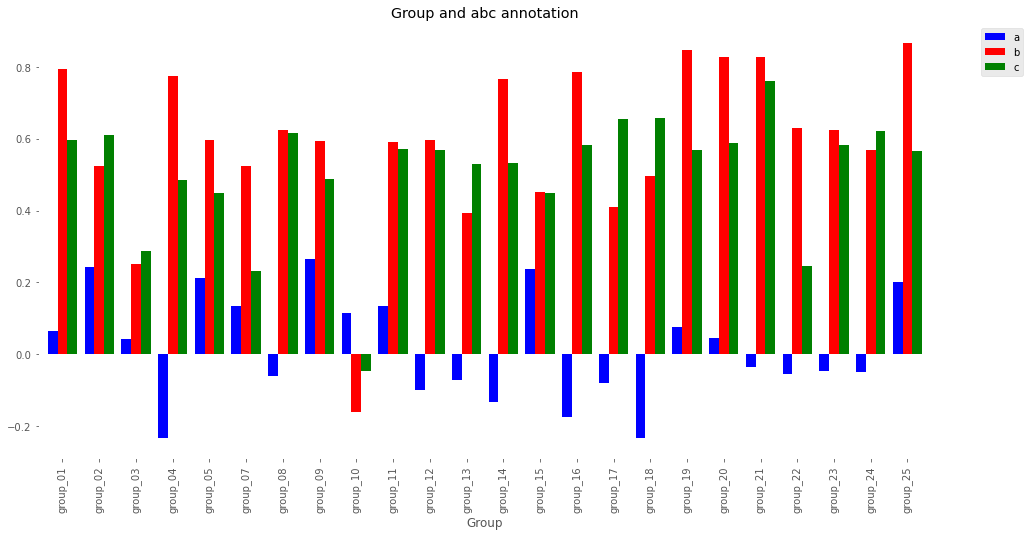

In [34]:
# plot the result
from matplotlib import pyplot as plt

plt.style.use('ggplot')    
f, ax = plt.subplots(figsize=(16,8))
output_p13_df.plot(kind='bar', x='group', sharex=True, ax=ax, rot=0, color=['b','r','g'], width=0.8)
ax.set_title("Group and abc annotation")
ax.set_xlabel("Group")
ax.grid(axis="y", color="grey")
ax.set_facecolor("white")
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()